📁 Found 360 daily parquet files


🔍 Scanning parquet files:   0%|                                                               | 0/360 [00:00<?, ?it/s]C:\Users\Nitro 5\AppData\Local\Temp\ipykernel_6316\412327134.py:25: PerformanceWarning: Determining the column names of a LazyFrame requires resolving its schema, which is a potentially expensive operation. Use `LazyFrame.collect_schema().names()` to get the column names without this warning.
  if "date" in lf.columns:
🔍 Scanning parquet files: 100%|█████████████████████████████████████████████████████| 360/360 [04:07<00:00,  1.46it/s]


✅ Applied winter + cold temperature filter
🔍 Checking delay unit...
Detected delay likely in seconds (avg=227.69) → converting to minutes
📉 Sampling up to 50,000,000 rows for visualization...
✅ Collected sample: (50000000, 12)
💾 Available RAM: 1.7 GB
⚠️ Reduced to 5M rows for plotting (RAM safeguard).

📊 Sample overview:
        date  hod           stop_id      delay          route_id  route_type  \
0 2024-01-17    5  9022001005071002  -1.783333  9011001004100000         100   
1 2024-01-02   14  9022001040463003   0.633333  9011001042100000         700   
2 2022-12-11   16  9022001062139002   0.200000  9011001062100000         700   
3 2024-01-01   23  9022001080573001   0.950000  9011001083400000         700   
4 2024-11-22    9  9022001051496003  13.183333  9011001051400000         700   

   direction_id  shape_dist_traveled  temperature  precipitation  snow_depth  \
0             0                  0.0         -2.0            0.3       7.391   
1             1               3210.0

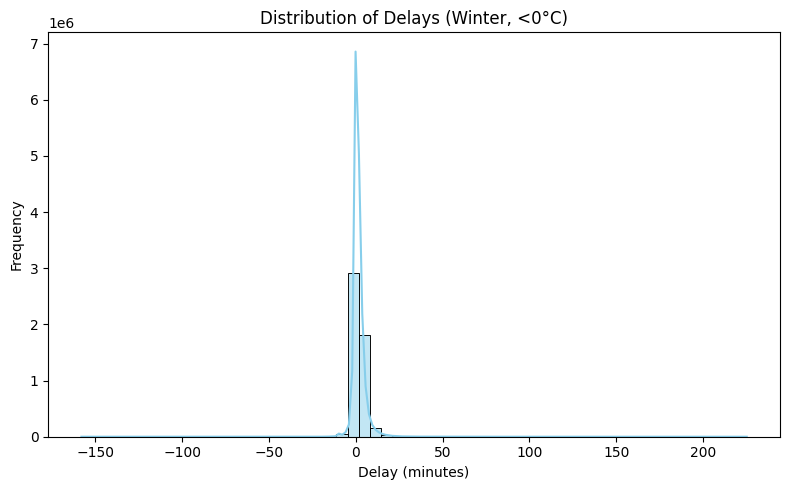

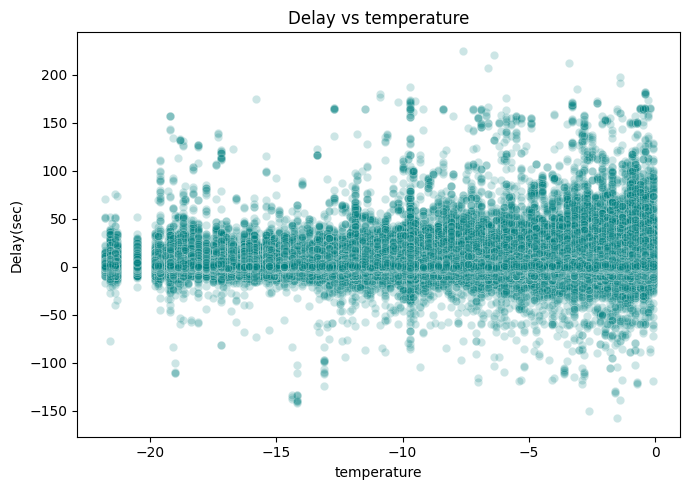

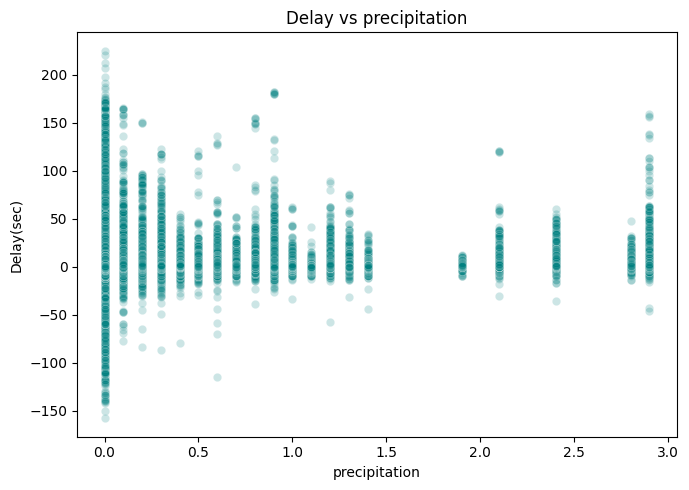

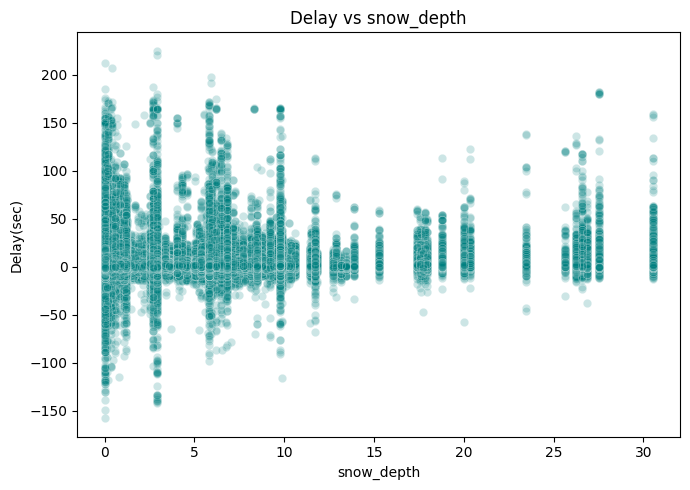

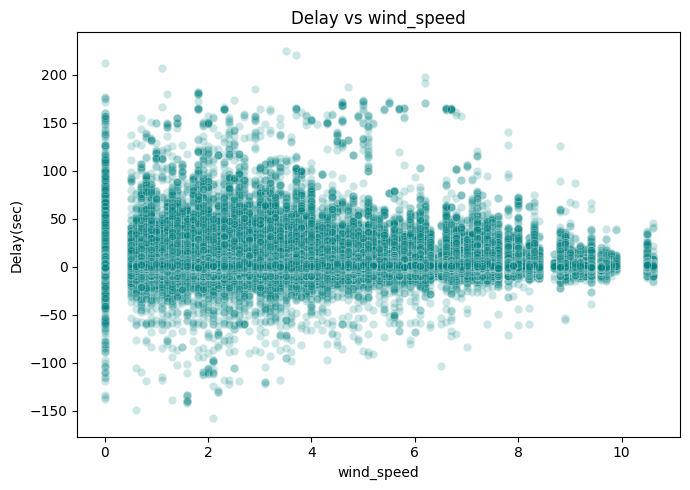

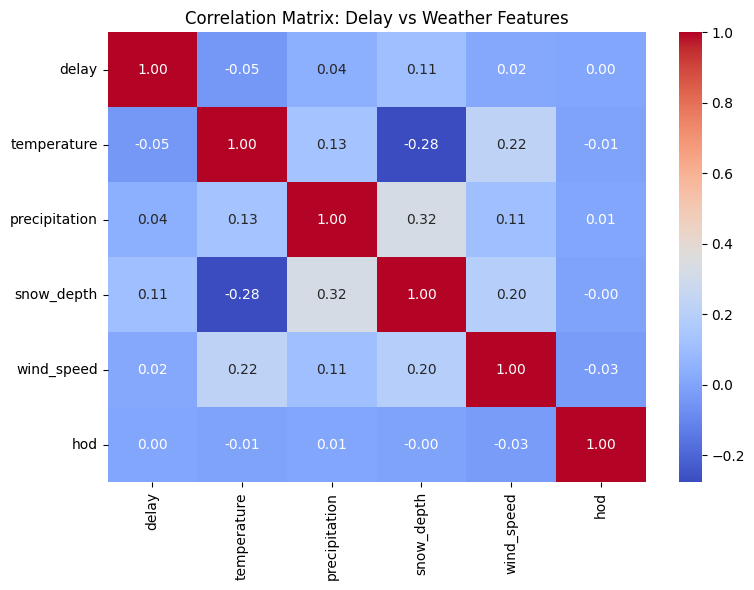

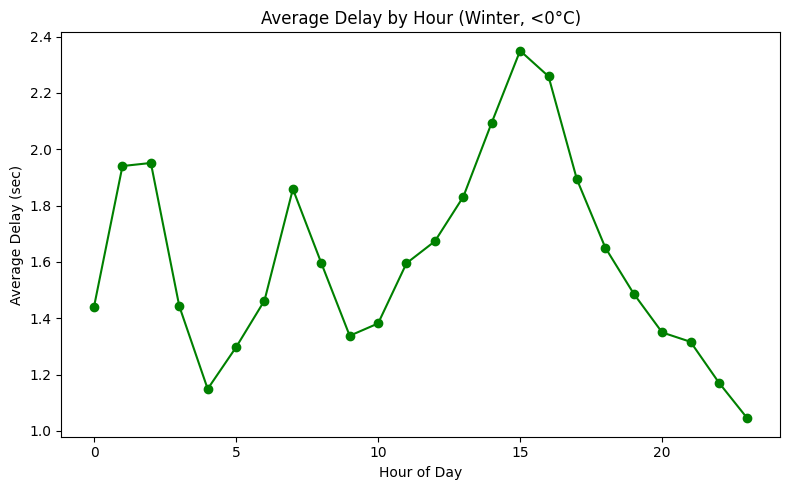

C:\Users\Nitro 5\AppData\Local\Temp\ipykernel_6316\412327134.py:153: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=route_avg, x="route_id", y="avg_delay", palette="viridis")


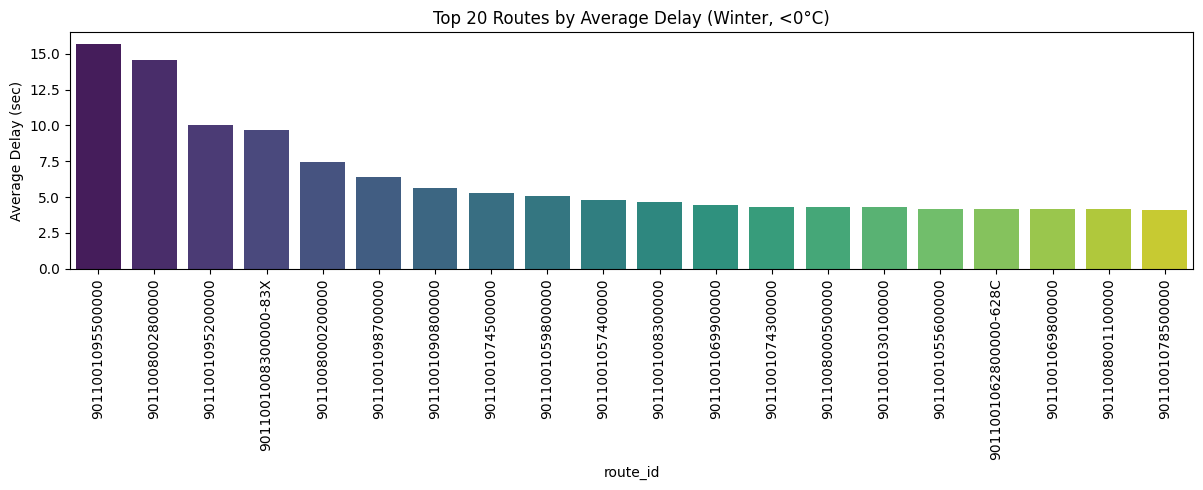

C:\Users\Nitro 5\AppData\Local\Temp\ipykernel_6316\412327134.py:169: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=dow_avg.index, y=dow_avg.values, palette="coolwarm")


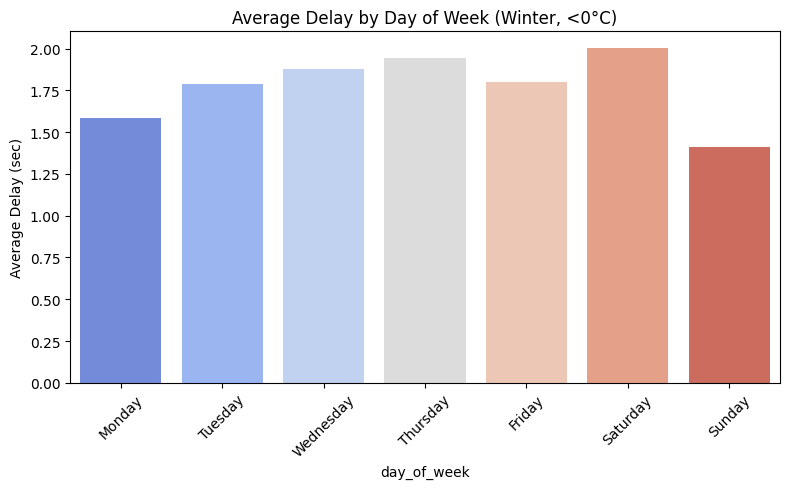

C:\Users\Nitro 5\AppData\Local\Temp\ipykernel_6316\412327134.py:181: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


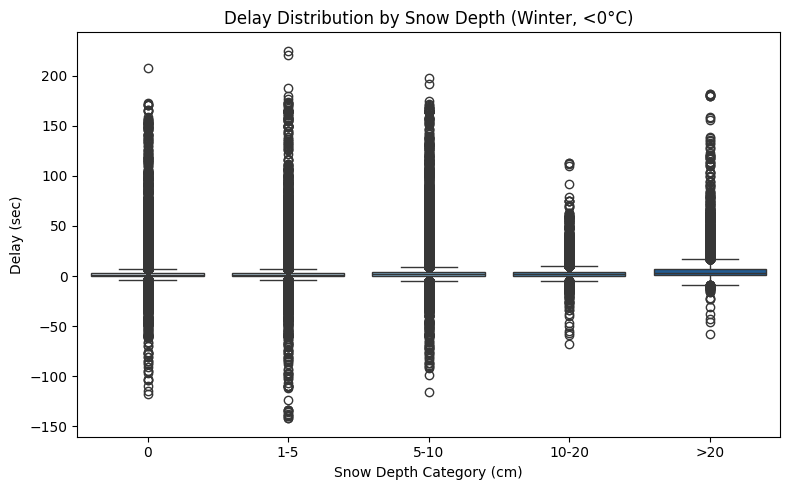

✅ EDA for winter season completed successfully.


In [1]:
# eda_winter_large.py
import os
import glob
import polars as pl
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import psutil

# -------------------------------
# 1️⃣ Load all parquet paths
# -------------------------------
base_dir = "preprocessed_daily"  # 🔧 change this path
all_parquet_paths = glob.glob(os.path.join(base_dir, "*", "0.parquet"))
print(f"📁 Found {len(all_parquet_paths)} daily parquet files")

# -------------------------------
# 2️⃣ Build LazyFrame combining all
# -------------------------------
lazy_frames = []
for path in tqdm(all_parquet_paths, desc="🔍 Scanning parquet files"):
    lf = pl.scan_parquet(path)
    # Force consistent schema
    if "date" in lf.columns:
        lf = lf.with_columns(pl.col("date").cast(pl.Utf8))
    lazy_frames.append(lf)

lf_all = pl.concat(lazy_frames)

# Convert 'date' to proper date type
lf_all = lf_all.with_columns(pl.col("date").str.strptime(pl.Date, "%Y-%m-%d", strict=False))

# -------------------------------
# 3️⃣ Filter for winter months & cold temps (<0°C)
# -------------------------------
lf_winter = lf_all.filter(
    (pl.col("date").dt.month().is_in([11, 12, 1, 2, 3, 4])) &
    (pl.col("temperature") < 0)
)

print("✅ Applied winter + cold temperature filter")

# --- Move this here ---
print("🔍 Checking delay unit...")
sample_delay = lf_winter.select(pl.col("delay")).limit(1_000_000).collect()
mean_delay = sample_delay["delay"].mean()

if mean_delay > 100:
    print(f"Detected delay likely in seconds (avg={mean_delay:.2f}) → converting to minutes")
    lf_winter = lf_winter.with_columns((pl.col("delay") / 60).alias("delay"))
else:
    print(f"Delay appears to already be in minutes (avg={mean_delay:.2f})")
# -----------------------


# -------------------------------
# 5️⃣ Sampling (up to 50 million rows)
# -------------------------------
sample_limit = 50_000_000
print(f"📉 Sampling up to {sample_limit:,} rows for visualization...")

filtered_df = lf_winter.limit(sample_limit).collect()
print(f"✅ Collected sample: {filtered_df.shape}")

available_ram_gb = psutil.virtual_memory().available / 1e9
print(f"💾 Available RAM: {available_ram_gb:.1f} GB")

if filtered_df.height <= 5_000_000 or available_ram_gb > 16:
    df = filtered_df.to_pandas()
    print(f"Converted to pandas for plotting → shape: {df.shape}")
else:
    df = filtered_df.sample(n=5_000_000).to_pandas()
    print("⚠️ Reduced to 5M rows for plotting (RAM safeguard).")

# -------------------------------
# 6️⃣ Data Overview
# -------------------------------
print("\n📊 Sample overview:")
print(df.head())
print("\nSummary statistics:")
print(df.describe())

# -------------------------------
# 7️⃣ Distribution of Delays
# -------------------------------
plt.figure(figsize=(8,5))
sns.histplot(df["delay"], bins=60, kde=True, color='skyblue')
plt.title("Distribution of Delays (Winter, <0°C)")
plt.xlabel("Delay (minutes)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# -------------------------------
# 8️⃣ Delay vs Weather (Scatter Plots)
# -------------------------------
weather_cols = ["temperature", "precipitation", "snow_depth", "wind_speed"]
for col in weather_cols:
    if col in df.columns:
        plt.figure(figsize=(7,5))
        sns.scatterplot(data=df, x=col, y="delay", alpha=0.2, color="teal")
        plt.title(f"Delay vs {col}")
        plt.xlabel(col)
        plt.ylabel("Delay(sec)")
        plt.tight_layout()
        plt.show()

# -------------------------------
# 9️⃣ Correlation Matrix
# -------------------------------
corr_features = ["delay", "temperature", "precipitation", "snow_depth", "wind_speed", "hod"]
corr_matrix = df[corr_features].corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix: Delay vs Weather Features")
plt.tight_layout()
plt.show()

# -------------------------------
# 🔟 Average Delay per Hour
# -------------------------------
hourly_avg = (
    lf_winter.group_by("hod")
    .agg(pl.col("delay").mean().alias("avg_delay"))
    .sort("hod")
    .collect()
    .to_pandas()
)

plt.figure(figsize=(8,5))
plt.plot(hourly_avg["hod"], hourly_avg["avg_delay"], marker="o", color="green")
plt.xlabel("Hour of Day")
plt.ylabel("Average Delay (sec)")
plt.title("Average Delay by Hour (Winter, <0°C)")
plt.tight_layout()
plt.show()

# -------------------------------
# 11️⃣ Average Delay by Route
# -------------------------------
route_avg = (
    lf_winter.group_by("route_id")
    .agg(pl.col("delay").mean().alias("avg_delay"))
    .sort("avg_delay", descending=True)
    .limit(20)
    .collect()
    .to_pandas()
)

plt.figure(figsize=(12,5))
sns.barplot(data=route_avg, x="route_id", y="avg_delay", palette="viridis")
plt.xticks(rotation=90)
plt.ylabel("Average Delay (sec)")
plt.title("Top 20 Routes by Average Delay (Winter, <0°C)")
plt.tight_layout()
plt.show()

# -------------------------------
# 12️⃣ Average Delay by Day of Week
# -------------------------------
df["day_of_week"] = pd.to_datetime(df["date"]).dt.day_name()
dow_avg = df.groupby("day_of_week")["delay"].mean().reindex(
    ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
)

plt.figure(figsize=(8,5))
sns.barplot(x=dow_avg.index, y=dow_avg.values, palette="coolwarm")
plt.xticks(rotation=45)
plt.ylabel("Average Delay (sec)")
plt.title("Average Delay by Day of Week (Winter, <0°C)")
plt.tight_layout()
plt.show()

# -------------------------------
# 13️⃣ Boxplot of Delay vs Snow Depth
# -------------------------------
if "snow_depth" in df.columns:
    plt.figure(figsize=(8,5))
    sns.boxplot(
        data=df[df["snow_depth"] < 50],  # limit outliers
        x=pd.cut(df["snow_depth"], bins=[0,1,5,10,20,50], labels=["0","1-5","5-10","10-20",">20"]),
        y="delay",
        palette="Blues"
    )
    plt.title("Delay Distribution by Snow Depth (Winter, <0°C)")
    plt.xlabel("Snow Depth Category (cm)")
    plt.ylabel("Delay (sec)")
    plt.tight_layout()
    plt.show()

# -------------------------------
# ✅ Done
# -------------------------------
print("✅ EDA for winter season completed successfully.")


In [2]:
lf_winter = lf_all.filter(
    (pl.col("date").dt.month().is_in([11, 12, 1, 2, 3, 4])) &
    (pl.col("temperature") < 0)
)

print("✅ Applied winter + cold temperature filter")

# --- Move this here ---
print("🔍 Checking delay unit...")
sample_delay = lf_winter.select(pl.col("delay")).limit(1_000_000).collect()
mean_delay = sample_delay["delay"].mean()

if mean_delay > 100:
    print(f"Detected delay likely in seconds (avg={mean_delay:.2f}) → converting to minutes")
    lf_winter = lf_winter.with_columns((pl.col("delay") / 60).alias("delay"))
else:
    print(f"Delay appears to already be in minutes (avg={mean_delay:.2f})")

✅ Applied winter + cold temperature filter
🔍 Checking delay unit...
Detected delay likely in seconds (avg=227.69) → converting to minutes
